[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/fisamz/Repositorio_MCDAA/blob/main/Tarea6/Tarea6.ipynb)

# Tarea 6 — Algoritmos Supervisados (Pronóstico)
**Alumno:** Fisam Zavala  
**Dataset:** Mental Health and Lifestyle Habits (2019–2024)  
**Fuente:** [Kaggle – Atharva Soundankar](https://www.kaggle.com/datasets/atharvasoundankar/mental-health-and-lifestyle-habits-2019-2024)


In [4]:
# ==============================================
# TAREA 5 - Algoritmos Supervisados (Pronóstico)
# ==============================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import statsmodels.api as sm


# 1) Cargar el dataset
df = pd.read_csv("../Data/Mental_Health_Lifestyle_Dataset.csv")



BASE_DIR = "figures"             # carpeta base para exportar
FIG_DIR  = os.path.join(BASE_DIR)   # png/csv
TEX_DIR  = os.path.join(BASE_DIR)   # .tex (tablas)
os.makedirs(FIG_DIR, exist_ok=True)
os.makedirs(TEX_DIR, exist_ok=True)

# DataFrame -> tabular LaTeX (booktabs)

def df_to_booktabs_tabular(df: pd.DataFrame, align=None):
    if align is None:
        align = "l" + "r" * (df.shape[1] - 1)
    header = " & ".join(df.columns)
    lines = [r"\begin{tabular}{" + align + "}", r"\toprule", header + r" \\",
             r"\midrule"]
    for _, row in df.iterrows():
        cells = []
        for x in row.values:
            if isinstance(x, (int, float, np.floating)):
                cells.append(f"{x:.6f}")
            else:
                cells.append(str(x))
        lines.append(" & ".join(cells) + r" \\")
    lines.append(r"\bottomrule")
    lines.append(r"\end{tabular}")
    return "\n".join(lines)



Filas limpiadas por NaN: 0


,Parámetro,Coef,StdErr,t,pvalue,IC_2.5%,IC_97.5%
0,const,5.567624,0.419840,13.261,0.0000,4.744334,6.390914
1,Age,-0.006460,0.003885,-1.663,0.0964,-0.014078,0.001157
2,Sleep Hours,0.023654,0.034996,0.676,0.4992,-0.044972,0.092280
3,Work Hours per Week,-0.001474,0.004555,-0.324,0.7463,-0.010407,0.007458
4,Screen Time per Day (Hours),0.024857,0.029653,0.838,0.4020,-0.033291,0.083005
5,Social Interaction Score,-0.039963,0.020195,-1.979,0.0480,-0.079566,-0.000361
6,Gender Male,0.221474,0.127190,1.741,0.0818,-0.027941,0.470888
7,Gender Other,0.085338,0.126923,0.672,0.5014,-0.163554,0.334230
8,Exercise Level Low,-0.111248,0.127764,-0.871,0.3840,-0.361788,0.139292
9,Exercise Level Moderate,-0.196554,0.128851,-1.525,0.1273,-0.449225,0.056118


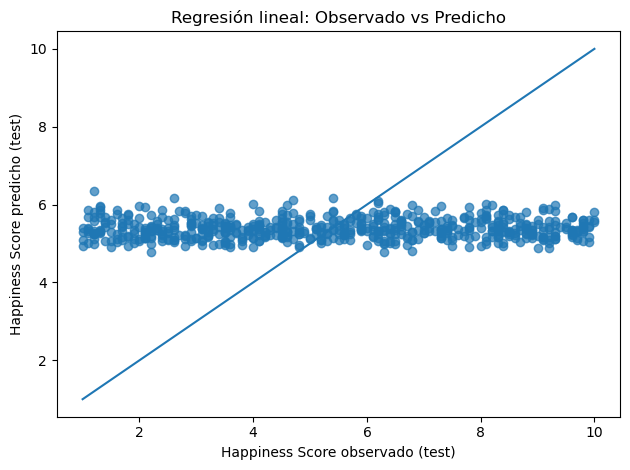

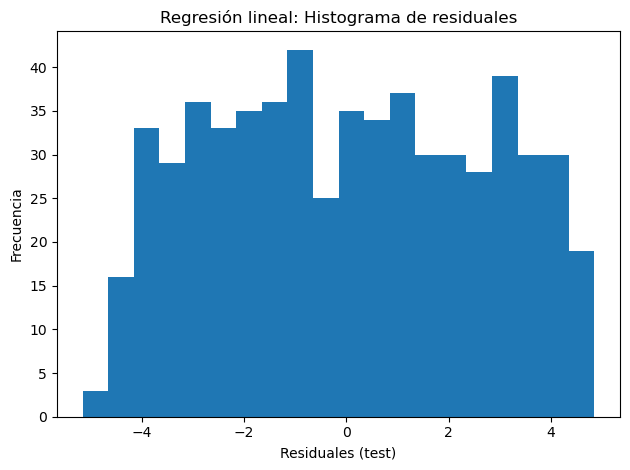

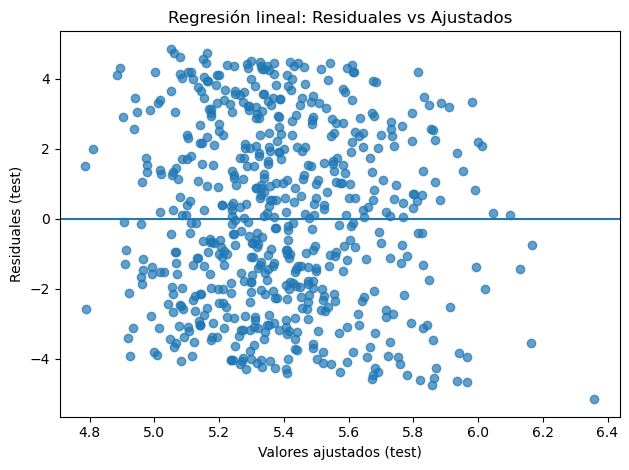

R² (train): 0.0108
R² (test):  -0.0032


In [24]:
# BLOQUE 1 — Setup y datos
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

# Carpeta donde guardarás tablas (.tex), figuras (.png) y trazabilidad (.csv)
BASE_DIR = "figures"
os.makedirs(BASE_DIR, exist_ok=True)

# Cargar dataset
df = pd.read_csv("../Data/Mental_Health_Lifestyle_Dataset.csv")

# Solo por higiene: copia y nos aseguramos que la columna objetivo exista
TARGET = "Happiness Score"
assert TARGET in df.columns, f"No existe la columna objetivo '{TARGET}'."


# BLOQUE 2 — Selección de variables y split
# Excluir 'Country' del análisis, si existe
cols_drop = [c for c in ["Country"] if c in df.columns]
work = df.drop(columns=cols_drop).dropna(subset=[TARGET]).copy()

X = work.drop(columns=[TARGET])
y = work[TARGET].astype(float)

# Detectar tipos
num_cols  = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols  = X.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

# Split (dejamos semilla para reproducibilidad)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)
len(X_train), len(X_test)

# BLOQUE 3 — Pipeline + ajuste del modelo
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), cat_cols),
        ("num", "passthrough", num_cols),
    ],
    remainder="drop",
)

linreg = LinearRegression()
pipe = Pipeline([("prep", preprocess), ("linreg", linreg)])
pipe.fit(X_train, y_train)

# Guardamos nombres de features transformados para usarlos después
oh = pipe.named_steps["prep"].named_transformers_.get("cat", None)
cat_names = oh.get_feature_names_out(cat_cols).tolist() if (oh and len(cat_cols)) else []
feature_names = cat_names + num_cols
len(feature_names)


# BLOQUE 4 — Predicciones y CSV
y_pred_test = pipe.predict(X_test)

pred_df = pd.DataFrame({
    "y_test": y_test.reset_index(drop=True),
    "y_pred": pd.Series(y_pred_test)
})
pred_csv_path = os.path.join(BASE_DIR, "regresion_predicciones_test.csv")
pred_df.to_csv(pred_csv_path, index=False)

pred_csv_path  # ruta del archivo exportado

# BLOQUE 5 — Coeficientes (sklearn) -> .tex booktabs
def df_to_booktabs_tabular(df: pd.DataFrame, align=None):
    if align is None:
        align = "l" + "r" * (df.shape[1] - 1)
    header = " & ".join(df.columns)
    lines = [r"\begin{tabular}{" + align + "}", r"\toprule", header + r" \\",
             r"\midrule"]
    for _, row in df.iterrows():
        row_str = []
        for x in row.values:
            if isinstance(x, (int, float, np.floating)):
                row_str.append(f"{x:.6f}")
            else:
                row_str.append(str(x))
        lines.append(" & ".join(row_str) + r" \\")
    lines += [r"\bottomrule", r"\end{tabular}"]
    return "\n".join(lines)


# Utilidad: escapar texto para LaTeX
def latex_escape(s: str) -> str:
    if not isinstance(s, str):
        return s
    # el orden importa (primero \)
    s = s.replace("\\", r"\\")
    s = s.replace("&", r"\&")
    s = s.replace("%", r"\%")
    s = s.replace("$", r"\$")
    s = s.replace("#", r"\#")
    s = s.replace("_", r"\_")
    s = s.replace("{", r"\{")
    s = s.replace("}", r"\}")
    s = s.replace("~", r"\textasciitilde{}")
    s = s.replace("^", r"\textasciicircum{}")
    return s

def df_to_booktabs_tabular(df: pd.DataFrame, align=None):
    # Escapar cabeceras
    df = df.copy()
    df.columns = [latex_escape(str(c)) for c in df.columns]
    # Escapar celdas de texto
    for col in df.columns:
        if df[col].dtype == object:
            df[col] = df[col].apply(latex_escape)

    if align is None:
        align = "l" + "r" * (df.shape[1] - 1)
    header = " & ".join(df.columns)
    lines = [r"\begin{tabular}{" + align + "}", r"\toprule", header + r" \\",
             r"\midrule"]
    for _, row in df.iterrows():
        out = []
        for x in row.values:
            if isinstance(x, (int, float, np.floating)) and pd.notna(x):
                out.append(f"{x:.6f}")
            else:
                out.append("" if pd.isna(x) else str(x))
        lines.append(" & ".join(out) + r" \\")
    lines += [r"\bottomrule", r"\end{tabular}"]
    return "\n".join(lines)



coef = pipe.named_steps["linreg"].coef_
coef_df = pd.DataFrame({"Feature": feature_names, "Coeficiente": coef})
coef_df["AbsCoef"] = coef_df["Coeficiente"].abs()
coef_df = coef_df.sort_values("AbsCoef", ascending=False).drop(columns="AbsCoef").reset_index(drop=True)

coef_df["Feature"] = coef_df["Feature"].str.replace("_", " ", regex=False)


coef_tex = df_to_booktabs_tabular(coef_df[["Feature", "Coeficiente"]], align="l r")
with open(os.path.join(BASE_DIR, "tabla_coeficientes_sklearn.tex"), "w", encoding="utf-8") as f:
    f.write(coef_tex)


coef_df.head(), coef_tex_path  # vista rápida y ruta exportada

# BLOQUE 6 — OLS (statsmodels) -> .tex booktabs

# 1) Dummies NUMÉRICAS (evita dtype object)
Xd = pd.get_dummies(X_train, drop_first=True, dtype=float)

# 2) Agregar constante explícita
Xd = sm.add_constant(Xd, has_constant="add")

# 3) Alinear y limpiar (sin NaN y todo float)
y_train_num = pd.to_numeric(y_train, errors="coerce")

data_sm = pd.concat([y_train_num.rename("y_sm"), Xd], axis=1)
before = len(data_sm)
data_sm = data_sm.dropna()
dropped = before - len(data_sm)

y_sm = data_sm["y_sm"].astype(float)
X_sm = data_sm.drop(columns=["y_sm"]).astype(float)

# Seguridad: no deben quedar columnas object
obj_cols = X_sm.select_dtypes(include=["object"]).columns.tolist()
if obj_cols:
    raise TypeError(f"Quedaron columnas de tipo object: {obj_cols}")

# 4) Ajustar OLS
ols = sm.OLS(y_sm, X_sm, hasconst=True).fit()

# 5) Construir tabla ordenada
ols_tab = ols.summary2().tables[1].reset_index().rename(columns={"index": "Parámetro"})
ols_tab = ols_tab.rename(columns={
    "Coef.": "Coef", "Std.Err.": "StdErr", "P>|t|": "pvalue",
    "[0.025": "IC_2.5%", "0.975]": "IC_97.5%"
})
for c in ["Coef","StdErr","t","pvalue","IC_2.5%","IC_97.5%"]:
    ols_tab[c] = pd.to_numeric(ols_tab[c], errors="coerce")

ols_export = ols_tab.round({"Coef":6,"StdErr":6,"t":3,"pvalue":4,"IC_2.5%":6,"IC_97.5%":6})

ols_export["Parámetro"] = ols_export["Parámetro"].str.replace("_", " ", regex=False)

ols_tex = df_to_booktabs_tabular(
    ols_export[["Parámetro","Coef","StdErr","t","pvalue","IC_2.5%","IC_97.5%"]],
    align="l r r r r r r"
)

ols_export = ols_export[["Parámetro","Coef","StdErr","t","pvalue","IC_2.5%","IC_97.5%"]]
ols_tex = df_to_booktabs_tabular(ols_export, align="l r r r r r r")
with open(os.path.join(BASE_DIR, "tabla_coeficientes_statsmodels.tex"), "w", encoding="utf-8") as f:
    f.write(ols_tex)

print(f"Filas limpiadas por NaN: {dropped}")
display( ols_export ), ols_tex_path


# BLOQUE 7 — Figuras diagnósticas -> .png

# a) Observado vs Predicho (test)
plt.figure()
plt.scatter(y_test, y_pred_test, alpha=0.7)
mn = float(min(y_test.min(), y_pred_test.min()))
mx = float(max(y_test.max(), y_pred_test.max()))
plt.plot([mn, mx], [mn, mx])
plt.xlabel("Happiness Score observado (test)")
plt.ylabel("Happiness Score predicho (test)")
plt.title("Regresión lineal: Observado vs Predicho")
plt.tight_layout()
fig1_path = os.path.join(BASE_DIR, "regresion_real_vs_predicho.png")
plt.savefig(fig1_path, dpi=300)
plt.show()

# b) Histograma de residuales (test)
resid = y_test - y_pred_test
plt.figure()
plt.hist(resid, bins=20)
plt.xlabel("Residuales (test)")
plt.ylabel("Frecuencia")
plt.title("Regresión lineal: Histograma de residuales")
plt.tight_layout()
fig2_path = os.path.join(BASE_DIR, "regresion_residuales_hist.png")
plt.savefig(fig2_path, dpi=300)
plt.show()

# c) Residuales vs Ajustados (test)
plt.figure()
plt.scatter(y_pred_test, resid, alpha=0.7)
plt.axhline(0)
plt.xlabel("Valores ajustados (test)")
plt.ylabel("Residuales (test)")
plt.title("Regresión lineal: Residuales vs Ajustados")
plt.tight_layout()
fig3_path = os.path.join(BASE_DIR, "regresion_residuales_vs_ajustados.png")
plt.savefig(fig3_path, dpi=300)
plt.show()

(fig1_path, fig2_path, fig3_path)

r2_train = pipe.score(X_train, y_train)
r2_test = pipe.score(X_test, y_test)

print(f"R² (train): {r2_train:.4f}")
print(f"R² (test):  {r2_test:.4f}")
